# Chuẩn bị dữ liệu

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [22]:
# Đọc dữ liệu
df = pd.read_csv('AEP_hourly.csv')

# Chuẩn hoá Datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

print(df.info())
print(df.head().to_markdown())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB
None
| Datetime            |   AEP_MW |
|:--------------------|---------:|
| 2004-10-01 01:00:00 |    12379 |
| 2004-10-01 02:00:00 |    11935 |
| 2004-10-01 03:00:00 |    11692 |
| 2004-10-01 04:00:00 |    11597 |
| 2004-10-01 05:00:00 |    11681 |


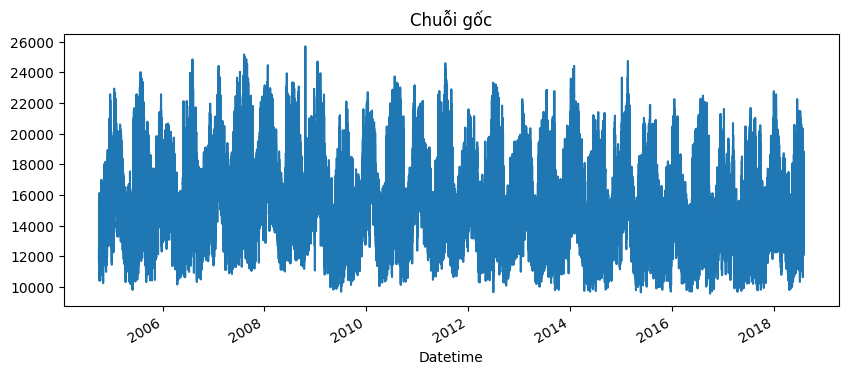

In [23]:
# Trực quan hoá chuỗi gốc
df['AEP_MW'].plot(figsize=(10, 4), title='Chuỗi gốc')
plt.show()

# Tạo lag features (Supervised Learning) 

In [24]:
def create_lag(df, p_lags):
    df_n = df.copy()
    for i in range(1, p_lags + 1):
        # Sử dụng hàm shift(i) để lấy giá trị quá khứ thứ i
        df_n[f'lag_{i}'] = df_n['AEP_MW'].shift(i)
    return df_n

In [25]:
p = 24 # sử dụng 24 giờ trước để dự báo
df_with_lags = create_lag(df, p)

# Loại bỏ các hàng có giá trị NaN do quá trình dịch chuyển
df_with_lags = df_with_lags.dropna()

# Chia X-y

In [26]:
# X là các cột đặc trưng trễ, y là giá trị mục tiêu cần dự báo
features = [f'lag_{i}' for i in range(1, p+ 1)]
target = 'AEP_MW'

X = df_with_lags[features]
y = df_with_lags[target]

# Chia train / test theo thời gian 

In [27]:
split = int(len(df_with_lags) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# XGBoost

In [28]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# Dự đoán và đánh giá


In [29]:
y_pred = model.predict(X_test)

#Tính toán MAE MSE MAPE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")



MAE : 169.82
RMSE: 225.80
MAPE: 1.18%


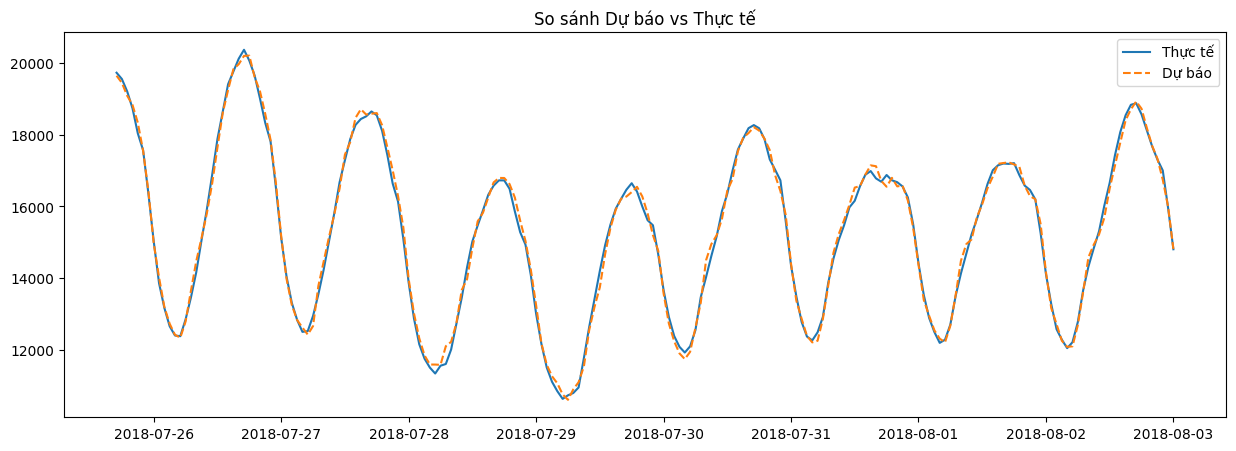

In [30]:
# Trực quan hóa kết quả dự báo so với thực tế (lấy 200 giờ cuối)
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[-200:], y_test.values[-200:], label='Thực tế')
plt.plot(y_test.index[-200:], y_pred[-200:], label='Dự báo', linestyle='--')
plt.legend()
plt.title('So sánh Dự báo vs Thực tế')
plt.show()

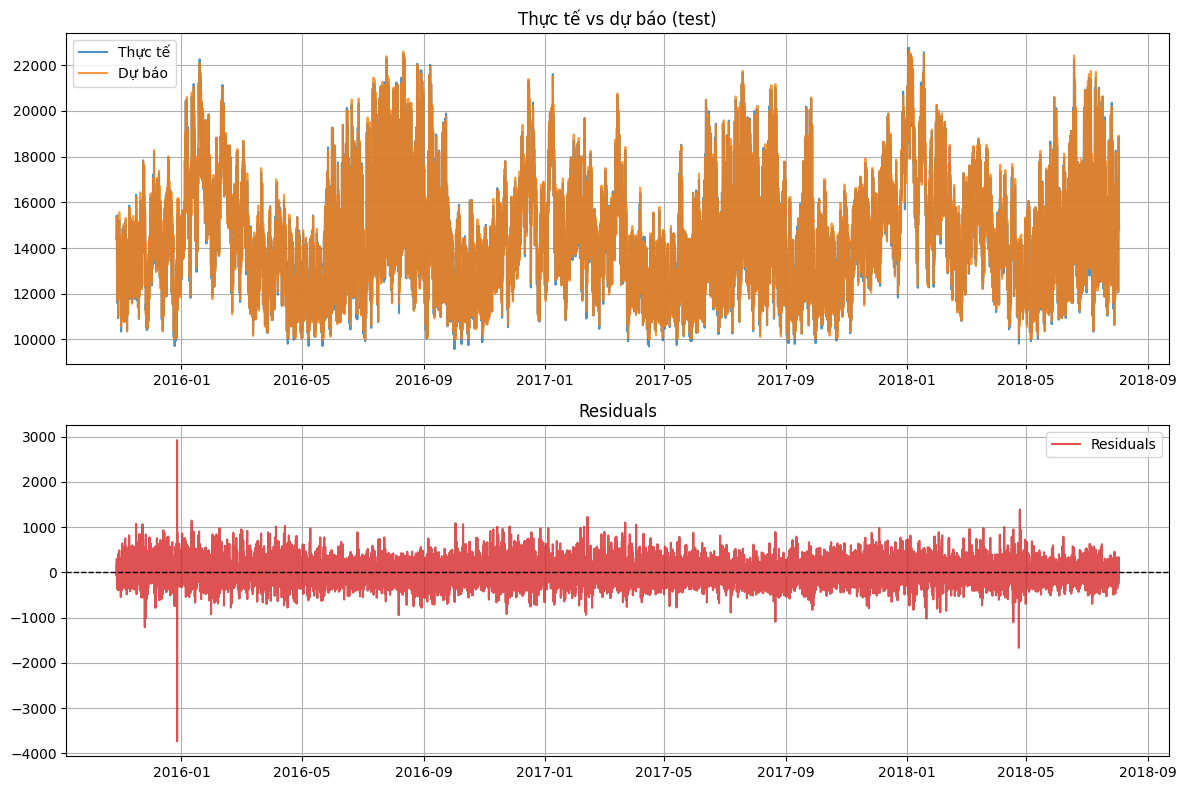

In [31]:
# So sánh thực tế vs dự báo (tập test) và residuals
test_pred_df = pd.DataFrame({
    "actual": y_test,
    "pred": y_pred
})
residuals = test_pred_df["actual"] - test_pred_df["pred"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
axes[0].plot(test_pred_df.index, test_pred_df["actual"], label="Thực tế", alpha=0.8)
axes[0].plot(test_pred_df.index, test_pred_df["pred"], label="Dự báo", alpha=0.8)
axes[0].set_title("Thực tế vs dự báo (test)")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(residuals.index, residuals.values, label="Residuals", color="tab:red", alpha=0.8)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Residuals")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

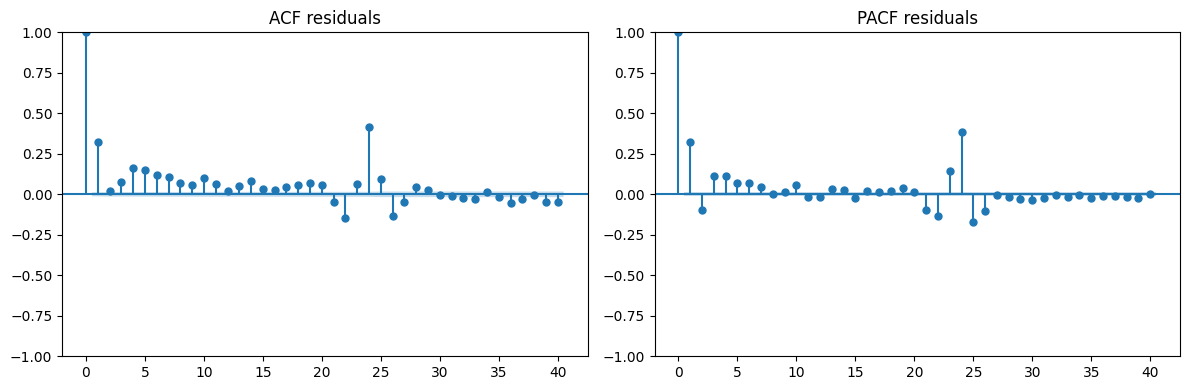

In [32]:
# ACF và PACF của residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resid_clean = residuals.dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(resid_clean, lags=40, ax=axes[0])
axes[0].set_title("ACF residuals")
plot_pacf(resid_clean, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF residuals")
plt.tight_layout()
plt.show()


# Phân tích feature importance để tìm hiểu lag nào ảnh hưởng mạnh nhất đến dự báo 

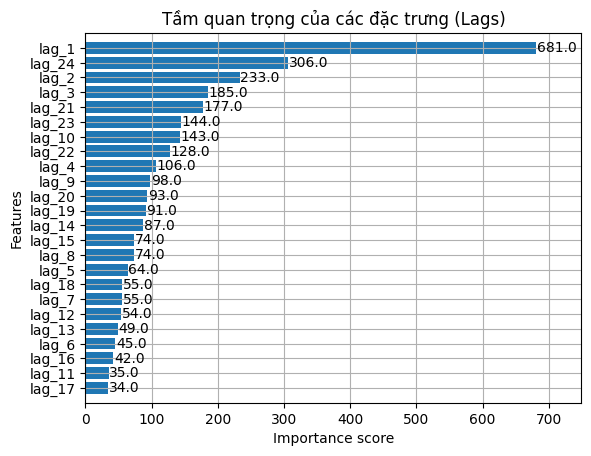

In [33]:
# Tìm hiểu lag nào ảnh hưởng mạnh nhất đến dự báo 
xgb.plot_importance(model, height=0.8)
plt.title('Tầm quan trọng của các đặc trưng (Lags)')
plt.show()